# Import

In [1]:
pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=c60c8a85c04244824fdeb2f4493e342c3b8fc5daced939c05bc7f3687b44c7af
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


In [2]:
#from sympy import*
import numpy as np
from pyDOE import lhs         #Latin Hypercube Sampling
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp #TFP needs TF>= 2.3
import scipy.optimize as opt
import time

tf.random.set_seed(1234)
np.random.seed(1234)

# Setting

In [197]:


a = 10.0
b = 10.0
eta = 2.0

def u1_ic(x,t):
    results = np.zeros(shape=x.shape)
    mask = (x>=0.0)&(x<=0.5)
    results[mask] = np.sin(2*np.pi*x[mask])
    return results
def u2_ic(x,t):
    results = np.zeros(shape=x.shape)
    mask = (x>0.5)&(x<=1.0)
    results[mask] = -np.sin(2*np.pi*x[mask])
    return results


def u1_bc(x,t):
    return np.zeros(shape=x.shape)

def u2_bc(x,t):
    return np.zeros(shape=x.shape)

# TrainingData & TestData

In [102]:
def trainingdata(N_u,N_f,omga,u_ic,u_bc):    

    x_range = omga[0]
    t_range = omga[1]

    all_X_u_train = []
    all_u_train = []

    # Initial Condition t=0, 
    lb = np.array([x_range[0],t_range[0]])
    ub = np.array([x_range[1],t_range[0]])
    initial_X = lb + (ub-lb)*lhs(2,N_u)
    initial_u = u_ic(initial_X[:,0],initial_X[:,1]).reshape(-1,1)
    
    all_X_u_train.append(initial_X)
    all_u_train.append(initial_u)

    # BC Condition

    lb = np.array([x_range[0],t_range[0]])
    ub = np.array([x_range[0],t_range[1]])
    BC_X1 = lb + (ub-lb)*lhs(2,N_u)
    BC_u1 = u_bc(BC_X1[:,0],BC_X1[:,1]).reshape(-1,1) 
    all_X_u_train.append(BC_X1)
    all_u_train.append(BC_u1) 
    
    lb = np.array([x_range[1],t_range[0]])
    ub = np.array([x_range[1],t_range[1]])
    BC_X2 = lb + (ub-lb)*lhs(2,N_u)
    BC_u2 = u_bc(BC_X2[:,0],BC_X2[:,1]).reshape(-1,1) 
    all_X_u_train.append(BC_X2)
    all_u_train.append(BC_u2) 

    all_X_u_train =  np.vstack(all_X_u_train)
    all_u_train = np.vstack(all_u_train)
    
    idx = np.random.choice(all_X_u_train.shape[0],all_X_u_train.shape[0], replace=False) 
    
    X_u_train = all_X_u_train[idx,:]
    u_train = all_u_train[idx,:]
            
    '''Collocation Points'''
    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    lb = np.array([x_range[0],t_range[0]])
    ub = np.array([x_range[1],t_range[1]])
    X_f_train = lb + (ub-lb)*lhs(2,N_f) 
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    return X_u_train,u_train,X_f_train

def ds_train_n_batch(X_u1_train,u1_train,X_u2_train,u2_train,X_f_train,n = 5):
    batch_u1 = int(len(X_u1_train)/n) # = int(len(u1_train)/n)


    batch_u2 = int(len(X_u2_train)/n) # = int(len(u2_train)/n)

    
    batch_f = int(len(X_f_train)/n)
    
    ds_u1 = tf.data.Dataset.from_tensor_slices( ((X_u1_train,u1_train)) ).batch( batch_u1 )
    
    ds_u2 = tf.data.Dataset.from_tensor_slices( ((X_u2_train,u2_train)) ).batch( batch_u2 )
    
    ds_f = tf.data.Dataset.from_tensor_slices(X_f_train).batch(batch_f)

    ds_train = tf.data.Dataset.zip((ds_u1,ds_u2,ds_f))
    return ds_train

def ds_test_n_batch(x1_test,u1_test,x2_test,u2_test,n=5):
  batch_u1 = int(len(u1_test)/n)
  batch_u2 = int(len(u2_test)/n)

  ds_u1 = tf.data.Dataset.from_tensor_slices( (x1_test,u1_test) ).batch(batch_u1)
  ds_u2 = tf.data.Dataset.from_tensor_slices( (x2_test,u2_test) ).batch(batch_u2)

  ds_test = tf.data.Dataset.zip((ds_u1,ds_u2))
  return ds_test

def test_data(N,omga,u):
  x_range = omga[0]
  t_range = omga[1]

  lb = np.array([x_range[0],t_range[0]])
  ub = np.array([x_range[1],t_range[1]])
  x_test = lb + (ub-lb)*lhs(2,N)
  u_test = u(x_test[:,0],x_test[:,1]).reshape((-1,1)) 

  return x_test,u_test

# Plot 

In [103]:
def plot_real_data(N,omga,u):
  # Output: X,T shape=(N,N)
  x_range = tf.linspace(omga[0][0],omga[0][1],N)
  t_range = tf.linspace(omga[1][0],omga[1][1],N)

  X,T = tf.meshgrid(x_range,t_range)

  U = u(X,T)
  return X,T,U

def plot_pred_data(X,T,model):
  #Input: X,T shape=(N,N)
  #Output: U_pred shape=(N,N)
  Shape = X.shape
  dim = len(Shape)
  X = tf.reshape(X,shape=(Shape[0]**dim,1))
  T = tf.reshape(T,shape=(Shape[0]**dim,1))

  Inputs = tf.concat([X,T],axis=1)
  U_pred = model(Inputs)
  U_pred = tf.reshape(U_pred,shape=Shape)
  return U_pred



In [104]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyparsing import col
#plt.rcParams['font.sans-serif'] = ['SimHei']  # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import math

In [105]:
def plot_Adam_history(history_saw_cp,start_epoch=0.05):

  fig = plt.figure(figsize=(10,6))
  ax1 = fig.add_subplot(211)
  epoches = len(history_saw_cp.history['loss'])
  start = int(epoches*start_epoch)
  x = np.arange(start,epoches,1)

  line1, = ax1.plot(x,history_saw_cp.history['loss'][start:],'g:')
  line2, = ax1.plot(x,history_saw_cp.history['loss_u1'][start:],'r:')
  line3, = ax1.plot(x,history_saw_cp.history['loss_u2'][start:],'b:')
  ax1.legend(handles=[line1,line2,line3],labels=['loss','loss_u1','loss_u2'])
  ax1.set_ylabel('loss')
  ax1.set_xlabel('epoches')
  ax1.autoscale()

  ax2 = fig.add_subplot(212)
  line4, = ax2.plot(x,history_saw_cp.history['val_err_u1'][start:],'r:')
  line5, = ax2.plot(x,history_saw_cp.history['val_err_u2'][start:],'b:')
  ax2.legend(handles=[line4,line5],labels=["err_u1","err_u2",])
  ax2.set_ylabel("error_rate")
  ax2.set_xlabel("epochs")
  ax2.autoscale()
  fig.suptitle("Adam")

  plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=1.0)
  plt.show()

  fig.savefig("3d_parabolic_Adam_history.png")
  return fig

In [106]:
def plot_Lbfgs_history(histroy,max_iterations):

  fig_lbfgs,ax = plt.subplots()
  ax.plot(histroy,'b:')
  ax.set_xlabel("num_objective_evaluations")
  ax.set_ylabel("loss")
  ax.set_title("L-BFGS Max_Iterations={}".format(max_iterations))
  
  plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=1.0)
  plt.show()

  fig_lbfgs.savefig("3d_parabolic_lbfgs_history.png")
  return fig_lbfgs

# PINN Model

## Single PINN

In [213]:
class SinglePinn(keras.Sequential): 
    def __init__(self,Layers,name = None): 
        super(SinglePinn, self).__init__(name=name)
        self.add(keras.Input(shape=(Layers[0],) ,dtype=tf.float64))
        for i in range(1,len(Layers)-1):
            self.add(keras.layers.Dense(Layers[i], dtype=tf.float64,
                kernel_regularizer=keras.regularizers.l2(0.01), 
                activity_regularizer=keras.regularizers.l1(0.01), 
                activation='tanh'))
        self.add(keras.layers.Dense(Layers[-1],dtype=tf.float64, name="outputs"))

    @tf.function
    def loss_U(self,X_u_train,u_train):
        u= self(X_u_train,training=True)
        loss_u = tf.reduce_mean(tf.square(u_train - u))
        return loss_u

## Coupled PINN

In [214]:
class CoupledPinnLoss(keras.losses.Loss):
  def __init__(self,model,name="pinn_loss"):
      super().__init__(name=name)
      self.model = model
  def __call__(self,X_u1_train,u1_train,X_u2_train,u2_train,X_f_train):
  
    loss_u1_BC = self.model.m1.loss_U(X_u1_train,u1_train)
    loss_u2_BC = self.model.m2.loss_U(X_u2_train,u2_train) 
    loss_u1_PDE,loss_u2_PDE = self.model.loss_PDE(X_f_train)

    loss_u1_total = loss_u1_BC + loss_u1_PDE 
    loss_u2_total = loss_u2_BC + loss_u2_PDE 

    loss = loss_u1_total + loss_u2_total
    return loss, loss_u1_total, loss_u2_total


In [215]:
class CoupledPinn(keras.Model):
  def __init__(self,model_u1,model_u2,a,b,eta,name=None):
    super().__init__(name=name)
    self.m1 = model_u1 
    self.m2 = model_u2
    self.a = tf.constant(a,dtype=tf.float64)
    self.b = tf.constant(b,dtype=tf.float64)
    self.eta = tf.constant(eta,dtype=tf.float64)

    # Metrics
    self.loss_tracker = keras.metrics.Mean(name="loss")
    self.loss_u1 = keras.metrics.Mean(name="loss_u1")
    self.loss_u2 = keras.metrics.Mean(name="loss_u2")

    self.u1_error = keras.metrics.Mean(name="err_u1")
    self.u2_error = keras.metrics.Mean(name="err_u2")
    
  @property
  def metrics(self):
      # We list our `Metric` objects here so that `reset_states()` can be
      # called automatically at the start of each epoch
      # or at the start of `evaluate()`.
      # If you don't implement this property, you have to call
      # `reset_states()` yourself at the time of your choosing.
      m = [self.loss_tracker,
           self.loss_u1,
           self.loss_u2,
           self.u1_error,
           self.u2_error]
      return m 

  @tf.function
  def loss_PDE(self,X_f_train):
      x = X_f_train[:,0:1]
      t = X_f_train[:,1:2]
    
      with tf.GradientTape(persistent=True) as tape:
          tape.watch([x,t])
          X = tf.stack([x[:,0],t[:,0]],axis=1)

          U1 = self.m1(X,training=True)
          U2 = self.m2(X,training=True)

          U1_x = tape.gradient(U1,x)
          U2_x = tape.gradient(U2,x)
      
      U1_xx = tape.gradient(U1_x, x)
      U2_xx = tape.gradient(U2_x, x)

      U1_t = tape.gradient(U1,t)
      U2_t = tape.gradient(U2,t)

      del tape

      loss_u1_PDE = U1_t - U1_xx + self.eta * U1 * U1_x + self.a * (U1_x * U2 + U1 * U2_x)
      loss_u2_PDE = U2_t - U2_xx + self.eta * U2 * U2_x + self.b * (U1_x * U2 + U1 * U2_x)

      loss_u1_PDE = tf.reduce_mean(tf.square(loss_u1_PDE)) 
      loss_u2_PDE = tf.reduce_mean(tf.square(loss_u2_PDE))

      return loss_u1_PDE,loss_u2_PDE
      

  """耦合区域 PINN训练方法"""
  @tf.function
  def train_step(self,data):
      (X_u1_train,u1_train),(X_u2_train,u2_train),X_f_train = data #unpack
      with tf.GradientTape(persistent=True) as tape: 
          loss,loss_u1_total,loss_u2_total = self.loss(X_u1_train,u1_train,X_u2_train,u2_train,X_f_train)
      
      # Compute gradients
      #gradients = tape.gradient(loss,self.trainable_variables)

      gradients_u1 = tape.gradient(loss,self.m1.trainable_variables)
      gradients_u2 = tape.gradient(loss,self.m2.trainable_variables)

      del tape

      # Updata parameters
      #self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))

      self.m1.optimizer.apply_gradients(zip(gradients_u1,self.m1.trainable_variables))
      self.m2.optimizer.apply_gradients(zip(gradients_u2,self.m2.trainable_variables))

      # Updata loss Metric
      self.loss_tracker.update_state(loss)
      self.loss_u1.update_state(loss_u1_total)
      self.loss_u2.update_state(loss_u2_total)


      metrics = {m.name : m.result() for m in self.metrics[:,-2]}

      return metrics

  @tf.function
  def test_step(self,data):
    (x1_test,u1_test),(x2_test,u2_test) = data
    # Updata test Metric
    u1_pred = self.m1(x1_test)
    u2_pred = self.m2(x2_test)
    err_u1 = tf.linalg.norm(u1_test-u1_pred) / tf.linalg.norm(u1_test)
    err_u2 = tf.linalg.norm(u2_test-u2_pred) / tf.linalg.norm(u2_test)  

    self.u1_error.update_state(err_u1) 
    self.u2_error.update_state(err_u2)
    
    return {self.u1_error.name:self.u1_error.result(),
            self.u2_error.name:self.u2_error.result()}

## Self-Adaptive-Weight Couple PINN

In [216]:
class SawCoupledPinnLoss(keras.losses.Loss):
  def __init__(self,model,name="saw_couple_pinn_loss"):
      super().__init__(name=name)
      self.model = model
  
  @tf.function
  def __call__(self,X_u1_train,u1_train,X_u2_train,u2_train,X_f_train):
  
    loss_u1_BC = self.model.m1.loss_U(X_u1_train,u1_train)
    loss_u2_BC = self.model.m2.loss_U(X_u2_train,u2_train) 
    loss_u1_PDE,loss_u2_PDE = self.model.loss_PDE(X_f_train)

    #loss_adaptive = (10*loss_u1_BC+loss_u1_PDE) + (10*loss_u2_BC+loss_u2_PDE)
    loss_adaptive = (10*loss_u1_BC+loss_u1_PDE) + self.model.alpha*(10*loss_u2_BC+loss_u2_PDE)

    # update alpha
    self.model.alpha.assign( (loss_u1_BC+loss_u1_PDE) /(loss_u2_BC+loss_u2_PDE+self.model.eps))

    return loss_adaptive, loss_u1_BC,loss_u2_BC, loss_u1_PDE,loss_u2_PDE

In [217]:
class SawCouplePinn(CoupledPinn):
  def __init__(self,model_u1,model_u2,a,b,eta,name=None):
    super().__init__(model_u1,model_u2,a,b,eta,name=name)
    # Self-Adaptive-Weights    
    self.eps = tf.constant(1e-10,dtype=tf.float64)
    self.alpha = tf.Variable(1.0,dtype = tf.float64, trainable = False, name='alpha')

  
  """Self-Adaptive-Weights 耦合PINN训练方法"""
  @tf.function
  def train_step(self,data):
  
      (X_u1_train,u1_train),(X_u2_train,u2_train),X_f_train = data #unpack
      with tf.GradientTape(persistent=True) as tape: 
          loss_adaptive,loss_u1_BC,loss_u2_BC,loss_u1_PDE,loss_u2_PDE = self.loss(X_u1_train,u1_train,X_u2_train,u2_train,X_f_train)

      loss_u1 = loss_u1_BC + loss_u1_PDE
      loss_u2 = loss_u2_BC + loss_u2_PDE
      loss = loss_u1 + loss_u2


      # Compute gradients
      #gradients = tape.gradient(loss_adaptive,self.trainable_variables)

      gradients_u1 = tape.gradient(loss_adaptive,self.m1.trainable_variables)
      gradients_u2 = tape.gradient(loss_adaptive,self.m2.trainable_variables)

      del tape

      # Update parameters
      #self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))

      self.m1.optimizer.apply_gradients(zip(gradients_u1,self.m1.trainable_variables))
      self.m2.optimizer.apply_gradients(zip(gradients_u2,self.m2.trainable_variables))

      # Updata loss Metric
      self.loss_tracker.update_state(loss)
      self.loss_u1.update_state(loss_u1)
      self.loss_u2.update_state(loss_u2)


      metrics = {m.name : m.result() for m in self.metrics[:-2]}

      return metrics

## function factory

In [218]:
def function_factory(model,X_u1_train,u1_train,X_u2_train,u2_train,X_f_train,untrainable_nums=0):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a loss function in model
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    if untrainable_nums == 0:
      shapes = tf.shape_n(model.trainable_variables[:])
    else:
      shapes = tf.shape_n(model.trainable_variables[:-untrainable_nums])
    n_tensors = len(shapes)
    trainable_nums = n_tensors

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = [] # stitch indices
    part = [] # partition indices

    for i, shape in enumerate(shapes):
          n = np.product(shape)
          idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
          part.extend([i]*n)
          count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """

        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """
        
        # update the parameters in the model
        assign_new_model_parameters(params_1d)
        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape() as tape:
            
            # calculate the loss
            loss_total = model.loss(X_u1_train,u1_train,X_u2_train,u2_train,X_f_train)[0]

        # calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_total, model.trainable_variables[:trainable_nums])
        grads = tf.dynamic_stitch(idx, grads)

        del tape

        # print out iteration & loss
        f.num_objective_evaluations.assign_add(1)
        if (f.num_objective_evaluations % 50 == 0) :
          tf.print("num_objective_evaluations:", f.num_objective_evaluations,
                   "loss:",loss_total)

        # store loss value and k so we can retrieve later
        tf.py_function(f.loss_history.append, inp=[loss_total], Tout=[])

        return loss_total, grads

    # store these information as members so we can use them outside the scope
    f.num_objective_evaluations = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.loss_history = []
    f.count = count

    return f

# Train

In [219]:
""" Training Data """

omga1 = [[0.,1.],[0.,1.]]  # (x,t)的取值范围 
omga2 = [[0.,1.],[0.,1.]]  # (x,t)的取值范围  



N_u1 = 400 ; N_f = 8000; omga = omga1;  
X_u1_train,u1_train,X_f_train= trainingdata(N_u1,N_f,omga,u1_ic,u1_bc)


N_u2 = 400; N_f = 8000; omga = omga2;  
X_u2_train,u2_train,X_f_train= trainingdata(N_u2,N_f,omga,u2_ic,u2_bc)


""" DataSet  """
ds_train = ds_train_n_batch(X_u1_train, u1_train,  X_u2_train , u2_train ,  X_f_train ,n = 1)

In [220]:
Layers=[2,40,40,40,40,40,40,40,40,1]

model_u1 = SinglePinn(Layers,name="model_u1")
model_u1.compile(optimizer=keras.optimizers.Adam())

model_u2 = SinglePinn(Layers,name="model_u2")
model_u2.compile(optimizer=keras.optimizers.Adam())


In [221]:
saw_couple_model=SawCouplePinn(model_u1,model_u2,a,b,eta,name="saw_couple_pinn");
saw_couple_model.compile( loss=SawCoupledPinnLoss(saw_couple_model),
          optimizer=keras.optimizers.Adam() )

In [223]:
history_saw_cp_1 = saw_couple_model.fit(ds_train,epochs=1000) #saw耦合PINN训练 Adam

Epoch 1/1000
1/1 [==============================] - 0s 223ms/step - loss: 0.1196 - loss_u1: 0.0686 - loss_u2: 0.0510
Epoch 2/1000
1/1 [==============================] - 0s 167ms/step - loss: 0.1207 - loss_u1: 0.0703 - loss_u2: 0.0504
Epoch 3/1000
1/1 [==============================] - 0s 150ms/step - loss: 0.1182 - loss_u1: 0.0677 - loss_u2: 0.0505
Epoch 4/1000
1/1 [==============================] - 0s 128ms/step - loss: 0.1207 - loss_u1: 0.0710 - loss_u2: 0.0497
Epoch 5/1000
1/1 [==============================] - 0s 137ms/step - loss: 0.1174 - loss_u1: 0.0669 - loss_u2: 0.0504
Epoch 6/1000
1/1 [==============================] - 0s 137ms/step - loss: 0.1245 - loss_u1: 0.0749 - loss_u2: 0.0496
Epoch 7/1000
1/1 [==============================] - 0s 145ms/step - loss: 0.1204 - loss_u1: 0.0681 - loss_u2: 0.0523
Epoch 8/1000
1/1 [==============================] - 0s 135ms/step - loss: 0.1421 - loss_u1: 0.0898 - loss_u2: 0.0523
Epoch 9/1000
1/1 [==============================] - 0s 151ms/ste

In [ ]:
saw_couple_model.save_weights("./ModelData/cBurgers_eg3/weights")

In [ ]:
saw_couple_model.load_weights("./ModelData/cBurgers_eg3/weights")

In [224]:
func = function_factory(saw_couple_model,X_u1_train,u1_train,X_u2_train,u2_train,X_f_train )

In [231]:

params_1d = tf.dynamic_stitch(func.idx, saw_couple_model.trainable_variables[:])
## L-BFGS 优化阶段
max_iterations = 4000
results = tfp.optimizer.lbfgs_minimize(
    value_and_gradients_function=func,
    initial_position=params_1d, 
    num_correction_pairs=20, 
    x_tolerance = 0,
    f_relative_tolerance = 0,
    tolerance = 1*np.finfo(float).eps,
    parallel_iterations = 1,
    max_line_search_iterations = 100,
    max_iterations=max_iterations)

num_objective_evaluations: 5850 loss: 0.0047983738814739952
num_objective_evaluations: 5900 loss: 0.0047585411042495827
num_objective_evaluations: 5950 loss: 0.00475716912981409
num_objective_evaluations: 6000 loss: 0.0047035201442195557
num_objective_evaluations: 6050 loss: 0.004682282504694435
num_objective_evaluations: 6100 loss: 0.0046675396513710665
num_objective_evaluations: 6150 loss: 0.0046426729181366722
num_objective_evaluations: 6200 loss: 0.0046285474222564939
num_objective_evaluations: 6250 loss: 0.0045964215044282846
num_objective_evaluations: 6300 loss: 0.0045770475233828595
num_objective_evaluations: 6350 loss: 0.0045533729687023995
num_objective_evaluations: 6400 loss: 0.0045286102905671959
num_objective_evaluations: 6450 loss: 0.00449758937413435
num_objective_evaluations: 6500 loss: 0.004470784245785675
num_objective_evaluations: 6550 loss: 0.0044372649282837344
num_objective_evaluations: 6600 loss: 0.0044164221532088255
num_objective_evaluations: 6650 loss: 0.004402

# Plotting

In [232]:
""" Plot Data """
N = 100
x_range = tf.linspace(omga1[0][0],omga1[0][1],N)
t_range = tf.linspace(omga1[1][0]+0.1,omga1[1][1]-0.6,N)
X_u1,T_u1 = tf.meshgrid(x_range,t_range)
U1_pred = plot_pred_data(X_u1,T_u1,model_u1)

x_range = tf.linspace(omga2[0][0],omga2[0][1],N)
t_range = tf.linspace(omga2[1][0]+0.1,omga2[1][1]-0.6,N)
X_u2,T_u2 = tf.meshgrid(x_range,t_range)
U2_pred = plot_pred_data(X_u2,T_u2,model_u2)

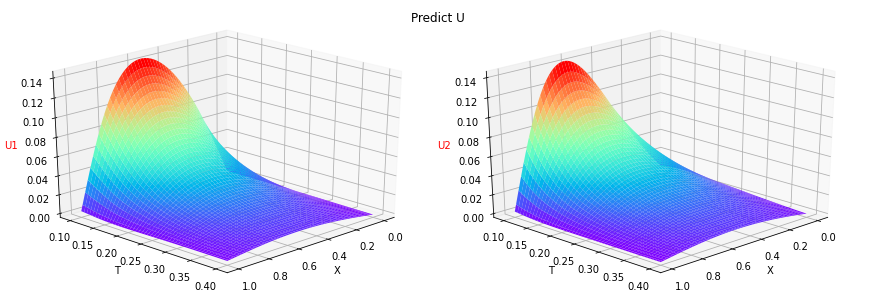

In [233]:
###################################################### 
fig2 = plt.figure(figsize=(12, 4)) 
fig2.suptitle("Predict U")
ax21 = fig2.add_subplot(121,projection="3d")
ax22 = fig2.add_subplot(122,projection="3d")

### u1
ax21.plot_surface(X_u1,T_u1,U1_pred,cmap='rainbow')
ax21.set_xlabel("X")   
ax21.set_ylabel("T")
ax21.set_zlabel("U1",color='r')

ax21.view_init(elev=25, azim=45)

### u2
ax22.plot_surface(X_u2,T_u2,U2_pred,cmap='rainbow')

ax22.set_xlabel("X")   
ax22.set_ylabel("T")
ax22.set_zlabel("U2",color='r',rotation='horizontal')

ax22.view_init(elev=25, azim=45)

plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=1.0)
fig2.savefig("2d_cBurgers_eg3_surface_pred.png")
###############################

plt.show()

# Max Value of U1/U2

In [234]:
class Func:
    def __init__(self,model,t=0.1):
        self.model = model
        self.t = 0.1
    def __call__(self,x):
        inputs = tf.constant([x[0],self.t],shape=(1,2))
        output = (-1*self.model(inputs)).numpy().squeeze()
        return output
t = 0.1
func_u1 = Func(model_u1,t=t)
func_u2 = Func(model_u2,t=t)

r_u1 = opt.minimize(func_u1,x0=(0.5,),bounds=((0.0,1.0),))
r_u2 = opt.minimize(func_u2,x0=(0.5,),bounds=((0.0,1.0),))

In [235]:
print("t = {}, Max value of u1: {}, At point: {}".format(t,-r_u1.fun,r_u1.x[0]))
print("t = {}, Max value of u2: {}, At point: {}".format(t,-r_u2.fun,r_u2.x[0]))

t = 0.1, Max value of u1: 0.1437306285792562, At point: 0.5814166933026186
t = 0.1, Max value of u2: 0.1433007282287982, At point: 0.6515883621941744


# Save Model

In [ ]:
saw_couple_model.save_weights("./ModelData/cBurgers_eg3/weights")